# 0. Setup and Imports

All of the python imports needed for running this notebook's code.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from transformers import pipeline

# 1. Load and Explore Dataset

In this project, we will be using the Jigsaw Toxic Comment Dataset, which can be found [here](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge).

## Load the dataset

In [ ]:
# use pandas to read the csv file
df = pd.read_csv('train.csv')
# remove any invalid rows
# df = df[['comment_text', 'toxic']].dropna()

## Data Exploration

In [ ]:
# Create a combined toxic column (toxic if any toxic label is present)
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['toxic_any'] = df[toxic_labels].max(axis=1)

In [ ]:
# Basic info
print("Dataset Overview:")
print(df.info())
print("\nIndividual Toxic Label Distribution:")
print(df[toxic_labels].sum())

print("\nCombined Toxic (toxic_any) Label Distribution:")
print(df['toxic_any'].value_counts())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   toxic_any      159571 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.0+ MB
None

Individual Toxic Label Distribution:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Combined Toxic (toxic_any) Label Distribution:
toxic_any
0    143346
1     16225
Name: count, dtype: int64


~160k total samples, ~16k are considered toxic

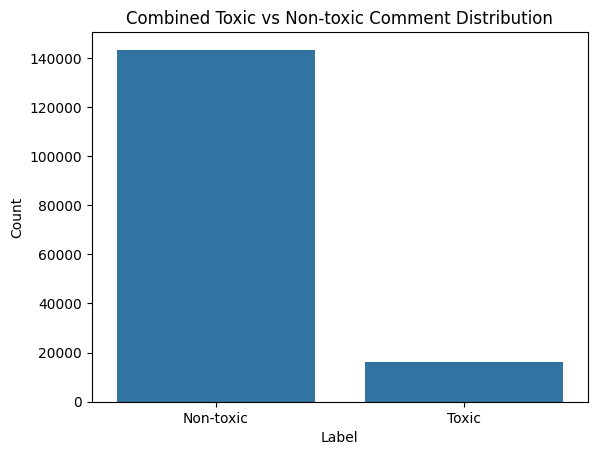

In [ ]:
# Plot class distribution
sns.countplot(data=df, x='toxic_any')
plt.xticks([0, 1], ['Non-toxic', 'Toxic'])
plt.title("Combined Toxic vs Non-toxic Comment Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

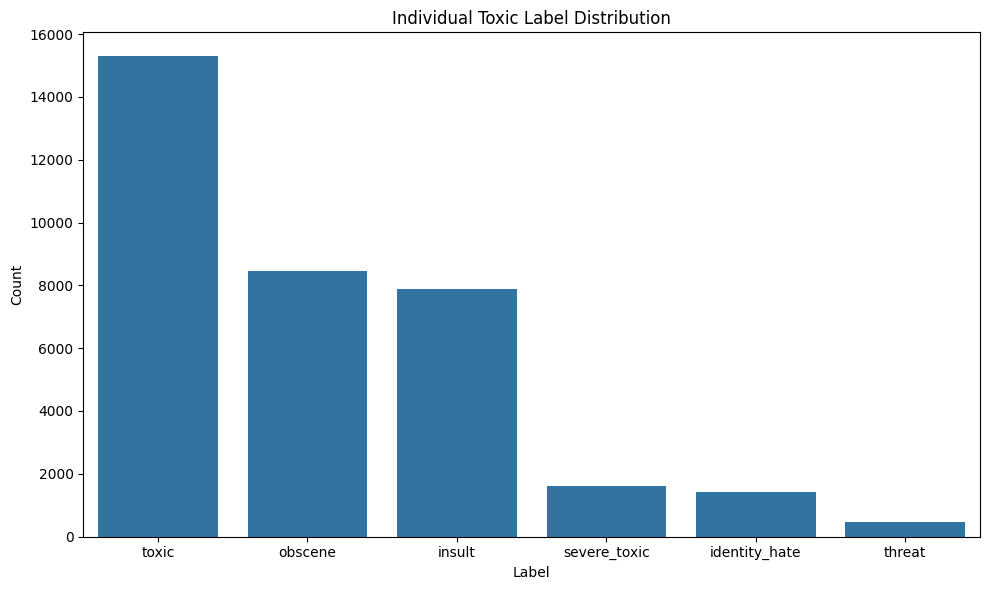

In [ ]:
# Count how many times each label appears
label_counts = df[toxic_labels].sum().sort_values(ascending=False)

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Individual Toxic Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Basic stats: comment length
df['length'] = df['comment_text'].apply(len)

print("\nAverage comment length (in characters):")
print(df.groupby('toxic_any')['length'].mean())


Average comment length (in characters):
toxic_any
0    404.347174
1    303.304037
Name: length, dtype: float64


In [ ]:
# Random samples
print("\nSample Toxic Comments:")
print(df[df['toxic_any'] == 1]['comment_text'].sample(3, random_state=1).values)

print("\nSample Non-Toxic Comments:")
print(df[df['toxic_any'] == 0]['comment_text'].sample(3, random_state=1).values)


Sample Toxic Comments:
["I Should be Surprised\n\nBut I'm not. Its exactly the kind of spineless response I anticipated from you. Look Schumin, I don't care about you remotely. I'm not here to bring you some sort of pain, I don't care anything, at all about you. What I do care about, and care about deeply is that the number one-stop shop for knowledge on the internet is even fractionally run by someone like you. This is a serious project, and attitudes like yours aren't needed. You are one of these people who wouldn't last a day on a serious academic venture, but sleazed your way onto Wikipedia and whored yourself as an admin. For you, being an admin is not the gruelling work it should be, its a status symbol. And thats sad. Thats really sad.\n\nNow, confront this head on for once in your life. Maybe your mother told you to ignore problems and they go away. I think you should confront your problem and apologise for your actions. 86.45.202.183"
 "No Irishlass I think that you are the o

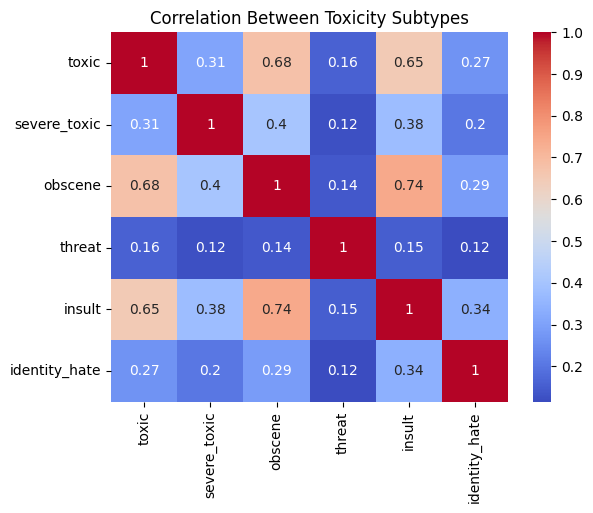

In [ ]:
# Correlation between labels (for analysis)
sns.heatmap(df[toxic_labels].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Toxicity Subtypes")
plt.show()

# 2. Logistic Regression Model & Results

First, we will train a logistic regression model on the full dataset.

For our own logistic regression model, we will be training and testing on the entire dataset, so we must first split the data into training data and test data, using an 80/20 split.

In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['comment_text'], # input
    df['toxic_any'], # output
    test_size=0.2, # 20% test, 80% train
    random_state=42
)

We must also prepare the data for inputting it into our model. We cannot just input plain text as the model would not be able to “understand” that, so instead we vectorize the text data to translate it into machine-readable numbers and attributes.


In [ ]:
# vectorize the input data
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Finally, we can define and train our model on the vectorized training set and evaluate the model on the test set.

In [ ]:
# train our logistic regression model
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

Evaluate the trained model on the test set.

In [ ]:
# predict test data with model
y_pred_log_reg = log_reg_model.predict(X_test_vec)

Classification report to show precision, recall, f1-score for each class, as well as total accuracy for the model.



In [ ]:
# classification report
print(classification_report(y_test, y_pred_log_reg, digits=4))

              precision    recall  f1-score   support

           0     0.9593    0.9941    0.9764     28671
           1     0.9229    0.6276    0.7472      3244

    accuracy                         0.9568     31915
   macro avg     0.9411    0.8108    0.8618     31915
weighted avg     0.9556    0.9568    0.9531     31915



It is important to note for analyzing results that about 90% of the samples in this dataset are classified as non-toxic, meaning that simply guessing non-toxic for all samples will already give us an accuracy of 90%. For that reason, it is important to not only measure accuracy, but also metrics like recall, precision, and f1-score.


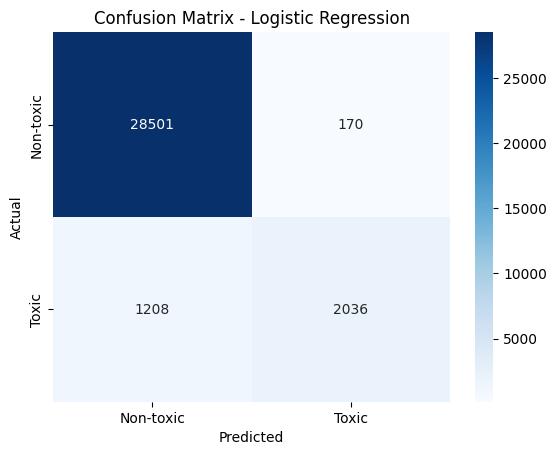

In [ ]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# 3. Pretrained LLM Classifier

We will use the unbiased-toxic-roberta LLM multiclassifier from HuggingFace. It can be found [here](https://huggingface.co/unitary/unbiased-toxic-roberta). This classifier is trained on many different datasets, including the one we are using for this project. The LLM outputs scores for 17 different labels, 6 of which correspond with the toxic labels from our specific dataset.

Our general methodology will be to check if any of these label scores surpass a certain threshold, and if so, we will have the LLM classifier classify that text as toxic.

In [ ]:
# import classifier

llm_classifier = pipeline("text-classification", model="unitary/unbiased-toxic-roberta")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cpu


This code below prints all of the labels contained in the LLM's classification.

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "unitary/unbiased-toxic-roberta"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Access the labels from config (if available)
print(model.config.id2label)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

{0: 'toxicity', 1: 'severe_toxicity', 2: 'obscene', 3: 'identity_attack', 4: 'insult', 5: 'threat', 6: 'sexual_explicit', 7: 'male', 8: 'female', 9: 'homosexual_gay_or_lesbian', 10: 'christian', 11: 'jewish', 12: 'muslim', 13: 'black', 14: 'white', 15: 'psychiatric_or_mental_illness'}


We will only test on 1000 samples from our dataset to get a grasp of the accuracy of the LLM. We can't run the whole dataset as classification takes quite a lot of computing power. Using the Colab CPU, we can only classify around 3 texts/second, which would not be feasible for our test set of around 30k that we used for logistic regression.

In [ ]:
# preprocess data, sample for speed
df_llm = df.sample(1000, random_state=42)

X_llm = df_llm['comment_text']
y_llm = df_llm['toxic_any']

We also have to define a function to make the predictions using the labels and scores output by the LLM. As mentioned before, this function classifies a sample as toxic if one of our desired labels has a score above a set threshold.

In [ ]:
# corresponding labels for our toxic_any key in the llm output
TOXIC_LABELS = {
    "toxicity",
    "severe_toxicity",
    "obscene",
    "threat",
    "insult",
    "identity_attack",
    "sexual_explicit"
}
# helper function for classification
def classify_llm(text, threshold=0.5):
    try:
        predictions = llm_classifier(text, top_k=None)
        # see if any of our labels are above the threshold
        for pred in predictions:
            if pred['label'] in TOXIC_LABELS:
                if pred['score'] > threshold:
                    return 1
        # if here, none of the labels were sufficient
        return 0
    except:
        return 0

Finally, we use this function to make predictions on our 1000 sample test set.


In [ ]:
# predict using LLM (~5 min runtime on CPU)
y_pred_llm = X_llm.apply(classify_llm, threshold=0.5)

Token indices sequence length is longer than the specified maximum sequence length for this model (840 > 512). Running this sequence through the model will result in indexing errors


Classification report to show precision, recall, f1-score for each class, as well as total accuracy for the model.

In [ ]:
# classification report
print(classification_report(y_llm, y_pred_llm, digits=4))

              precision    recall  f1-score   support

           0     0.9766    0.9777    0.9772       898
           1     0.8020    0.7941    0.7980       102

    accuracy                         0.9590      1000
   macro avg     0.8893    0.8859    0.8876      1000
weighted avg     0.9588    0.9590    0.9589      1000



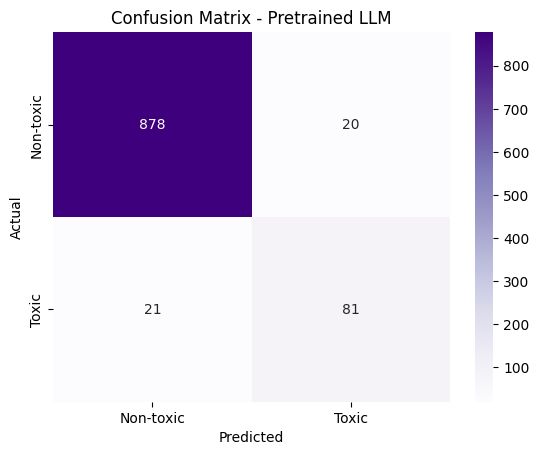

In [ ]:
# confusion matrix
cm_llm = confusion_matrix(y_llm, y_pred_llm)
sns.heatmap(cm_llm, annot=True, fmt='d', cmap='Purples', xticklabels=["Non-toxic", "Toxic"], yticklabels=["Non-toxic", "Toxic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Pretrained LLM')
plt.show()